In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

from PIL import Image
import os

from efficientnet_pytorch import EfficientNet
from torch.utils.tensorboard import SummaryWriter

In [36]:
# path
input_path = "/home/piai/바탕화면/hanja_crop_50/new50/output_crop/"

In [37]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [38]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print(labels)

tensor([3844, 4561, 4249, 3822,  834, 4509, 4713, 3959,  643, 3655, 4542, 2890,
        1300, 3947,  415, 1862, 2410, 2150,  561,  850, 1745,  103, 4144, 3556,
         895, 3269, 1044, 1054, 3868, 1031, 1581,  270])


In [39]:
classes = image_datasets['train'].classes

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## weight 파일 변경

In [41]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes = 4893).to(device)
model.load_state_dict(torch.load('/home/piai/바탕화면/hanja_crop_50/new50/eff_weights/best_weights_b5_class_30.pth'))

Loaded pretrained weights for efficientnet-b3


<All keys matched successfully>

## test 이미지 20개 랜덤추출

In [42]:
import random

path = "/home/piai/바탕화면/hanja_crop_50/new50/output_crop/test/"
file_list = os.listdir(path)

validation_img_paths = random.sample(file_list, 10)
val_img = []
for img_folder in validation_img_paths:
    val_img.append(path+img_folder+'/'+random.sample(os.listdir(path+img_folder), 1)[0])

In [43]:
img_list = [Image.open(input_path).convert('RGB') for input_path in val_img]

In [44]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [32]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ -5.8467,  -6.7434,   1.8020,  -6.0836,  -6.9207,   5.6179,   1.7210,
          -3.1613,  -6.5959,  -0.6501],
        [ -5.1896,   0.4192,  -1.8893,  -6.5199,  -8.2591,  -0.1690,  -2.1334,
          -5.1745,   8.3550,  -6.8689],
        [ -7.5878,  -6.7701,   4.6099,   1.3769,  -7.1018,  -7.3750,  -4.7078,
          -7.1272,  -5.3740,  11.6133],
        [ 14.2789,  -6.5196,   3.6524,   0.2028,  -4.1059,  -4.2528,  -5.3755,
          -1.2644,  -4.6272,   1.1918],
        [ -2.7913,   0.4545,  -0.2921,  -1.8583,  -4.3598,   0.4053,  -2.0032,
           6.9677,  -0.3637,  -4.8647],
        [ -3.5739,  -0.8091,   4.6800,  -2.5511,   8.5021,  -1.3028,  -1.1868,
          -3.5219,  -1.5811,  -1.2272],
        [ -6.3421,   7.2817,   0.4558,  -6.6800,  -8.1279,  -4.3412,  -3.6521,
          -3.9176,   1.0732,  -5.8630],
        [ -2.4279,  -4.1764,   2.2021,  -1.5861,  -8.3417,   0.2026,   3.8843,
          -1.7323,  -5.3720,  -2.4598],
        [-10.0793,  -8.5215,  25.1747,  -8.1329,

In [33]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[1.0049002e-05, 4.0990303e-06, 2.1080172e-02, 7.9292895e-06,
        3.4328471e-06, 9.5748681e-01, 1.9440172e-02, 1.4735642e-04,
        4.7505573e-06, 1.8152982e-03],
       [1.3102868e-06, 3.5746585e-04, 3.5535846e-05, 3.4644398e-07,
        6.0856962e-08, 1.9851839e-04, 2.7838700e-05, 1.3302306e-06,
        9.9937731e-01, 2.4438688e-07],
       [4.5778945e-09, 1.0370144e-08, 9.0792472e-04, 3.5808236e-05,
        7.4423867e-09, 5.6635758e-09, 8.1550553e-08, 7.2556596e-09,
        4.1888807e-08, 9.9905604e-01],
       [9.9997270e-01, 9.2749031e-10, 2.4264737e-05, 7.7058030e-07,
        1.0365395e-08, 8.9491063e-09, 2.9119567e-09, 1.7767840e-07,
        6.1541923e-09, 2.0717323e-06],
       [5.7511701e-05, 1.4769629e-03, 7.0005329e-04, 1.4619362e-04,
        1.1981949e-05, 1.4060421e-03, 1.2647599e-04, 9.9541581e-01,
        6.5164641e-04, 7.2324333e-06],
       [5.5709561e-06, 8.8444169e-05, 2.1406371e-02, 1.5492540e-05,
        9.7826457e-01, 5.3982509e-05, 6.0623013e-05, 5.86

## 폴더와 라벨링 매칭 파일

In [13]:
label_df = pd.read_csv('/home/piai/바탕화면/hanja_crop_50/new50/haeseo_label.csv', names = ['label', 'idx'])

In [14]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트
#font_name = fm.FontProperties(fname="/usr/share/fonts/nanum/NanumGothicExtraBold.ttf").get_name()
#plt.rc('font', family=font_name)

In [15]:
def max_prob(class_all, idx):
    _max = -99
    max_p = []
    for j in range(len(class_all)):
        if _max < pred_probs[idx,j]:
            _max = pred_probs[idx,j]
            max_p.append((pred_probs[idx,j], j))
            
    return max_p

In [16]:
label_df.head()

,label,idx
0,NaN,0
1,簧,1
2,霅,2
3,詫,3
4,垤,4


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


correct!!!!!!!!!!!!!!!!!!!!!!!!!!! 9


/home/piai/anaconda3/envs/jinmi/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38661 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/jinmi/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/jinmi/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/jinmi/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 149741 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/jinmi/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/envs/jinmi/lib/pyt

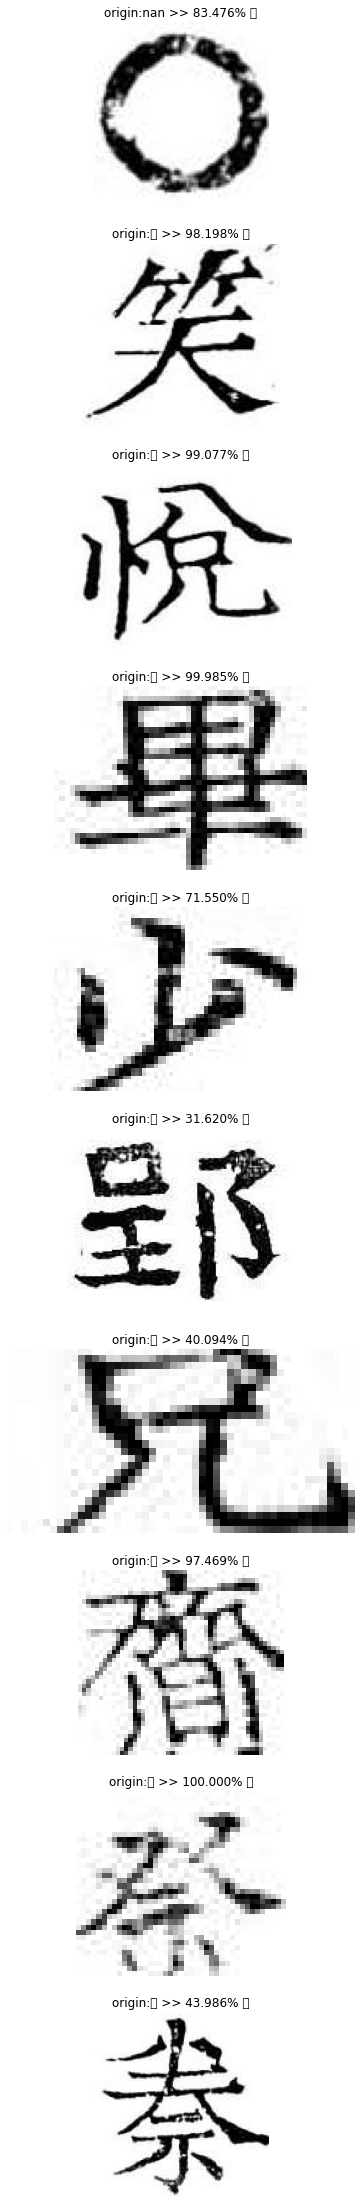

In [17]:
fig, axs = plt.subplots(len(img_list), 1, figsize=(15, 40))

corr_data = []
ori_data = []
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    max_list = max_prob(classes, i)
    
    ori_lb = label_df.at[int(validation_img_paths[i]), 'label']
    #lb1 = label_df.at[max_list[-2][1], 'label']
    lb2 = label_df.at[max_list[-1][1], 'label']
    corr_data.append(lb2)
    ori_data.append(ori_lb)
    if ori_lb == lb2:
        print("correct!!!!!!!!!!!!!!!!!!!!!!!!!!! %d"%i)
        
    #print(lb1, lb2)
    ax.set_title("origin:{} >> {:.3f}% {}".format(ori_lb,
                                                            100*max_list[-1][0], lb2))
    ax.imshow(img)
    
plt.show()

In [18]:
corr_data

['霅', '霅', '霅', '霅', '砠', '詫', '霅', '霅', '霅', '閎']

In [19]:
ori_data

[nan, '靄', '廉', '𤣭', '霅', '𥹭', '纖', '綾', '壬', '閎']

In [45]:
batch_size = 32
test_dataset = datasets.ImageFolder(input_path + 'test', data_transforms['train'])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        print(labels)
        print(predicted)
        # correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 95.44246673583984 %
